<a href="https://colab.research.google.com/github/arikmitra/KNN_Book_Recommendation/blob/main/KNN_Recommender_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2024-01-13 12:18:15--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M  92.1MB/s    in 0.3s    

2024-01-13 12:18:15 (92.1 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [ ]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [ ]:
# add your code here - consider creating a new cell for each section of code
#df_books.head(), df_ratings.head()

In [ ]:
df_ratings.columns, df_books.columns

(Index(['user', 'isbn', 'rating'], dtype='object'),
 Index(['isbn', 'title', 'author'], dtype='object'))

In [ ]:
#Exploring the data
df_books.describe(), df_ratings.describe()

(              isbn           title           author
 count       271379          271379           271378
 unique      271379          242154           102042
 top     0195153448  Selected Poems  Agatha Christie
 freq             1              27              632,
                user        rating
 count  1.149780e+06  1.149780e+06
 mean   1.403864e+05  2.866950e+00
 std    8.056228e+04  3.854184e+00
 min    2.000000e+00  0.000000e+00
 25%    7.034500e+04  0.000000e+00
 50%    1.410100e+05  0.000000e+00
 75%    2.110280e+05  7.000000e+00
 max    2.788540e+05  1.000000e+01)

array([[<Axes: xlabel='user', ylabel='user'>,
        <Axes: xlabel='rating', ylabel='user'>],
       [<Axes: xlabel='user', ylabel='rating'>,
        <Axes: xlabel='rating', ylabel='rating'>]], dtype=object)

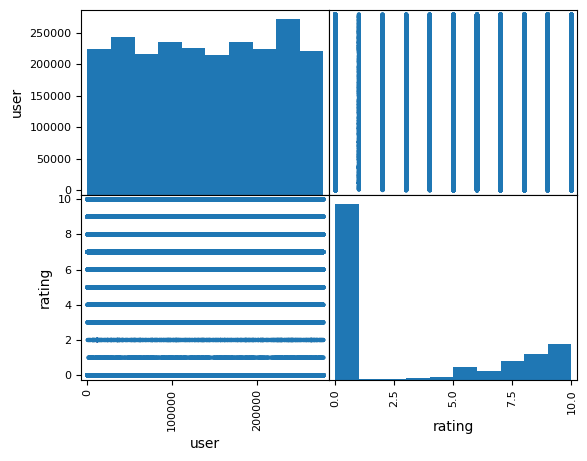

In [ ]:
pd.plotting.scatter_matrix(df_ratings)

<Axes: ylabel='Frequency'>

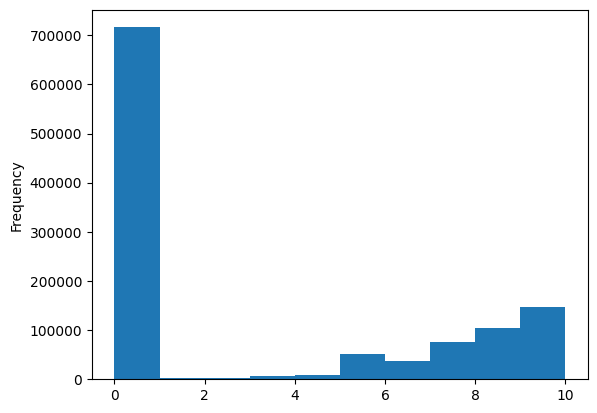

In [ ]:
df_ratings["rating"].plot(kind='hist') #most ratings are zero meaning no ratings given

In [ ]:
#Creating a dataframe out of the users and ratings
df = pd.merge(df_ratings, df_books, on="isbn")
df.head()

,user,isbn,rating,title,author
0,276725,034545104X,0.0,Flesh Tones: A Novel,M. J. Rose
1,2313,034545104X,5.0,Flesh Tones: A Novel,M. J. Rose
2,6543,034545104X,0.0,Flesh Tones: A Novel,M. J. Rose
3,8680,034545104X,5.0,Flesh Tones: A Novel,M. J. Rose
4,10314,034545104X,9.0,Flesh Tones: A Novel,M. J. Rose


In [ ]:
#Creating a copy keeping the master copy intact
df1 = df.copy()

In [ ]:
#Filtering out the indices with given criteria
user_index =  df1["user"].value_counts()[df1["user"].value_counts() >= 200].index
isbn_index = df1["isbn"].value_counts()[df1["isbn"].value_counts() >= 100].index

In [ ]:
#Creating dataframe with the indices
filtered_df =  df1.loc[(df1["user"].isin(user_index.values)) & (df1["isbn"].isin(isbn_index.values))]

In [ ]:
#Dropping duplicates. This will help us later in creating a sparse matrix
filtered_df = filtered_df.drop_duplicates(['title', 'user'])

In [ ]:
#Creating a sparse matrix for input to the KNN
knn_df = filtered_df.pivot(index = 'title', columns = 'user', values = 'rating').fillna(0)
knn_matrix_input = csr_matrix(knn_df.values)

In [ ]:
#Setting up and training the model
knn_model = NearestNeighbors(metric='cosine')
history = knn_model.fit(knn_matrix_input)

In [ ]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
  recommended_books = [book,[]]
  dist,idx = history.kneighbors([knn_df.loc[book]], 5, return_distance=True)

  recom_str = knn_df.iloc[np.flip(idx[0])[:-1]].index.to_list()
  recom_dist = list(np.flip(dist[0])[:-1])
  for i in zip(recom_str,recom_dist):
      recommended_books[1].append(i)

  return recommended_books

In [ ]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [('The Weight of Water', 0.7678344), ('The Surgeon', 0.76690507), ('I Know This Much Is True', 0.764642), ('The Lovely Bones: A Novel', 0.7158567)]]
You passed the challenge! 🎉🎉🎉🎉🎉
